In [84]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [85]:
path = kagglehub.dataset_download("jsphyg/weather-dataset-rattle-package")
print("Path to dataset files:", path)
filepath = path + "/weatherAUS.csv"
print("Path to main dataset:", filepath)
dataset = pd.read_csv(filepath)

Using Colab cache for faster access to the 'weather-dataset-rattle-package' dataset.
Path to dataset files: /kaggle/input/weather-dataset-rattle-package
Path to main dataset: /kaggle/input/weather-dataset-rattle-package/weatherAUS.csv


Беру меньше данных, так как иначе у меня падает любой третий метод из-за нехватки памяти

In [86]:
np.random.seed(52)
dataset = dataset.sample(n=10000, random_state=52).copy()

### Разделение на выборки:

In [87]:
X = dataset.drop(['RainTomorrow', 'Date', 'Location'], axis=1, errors='ignore')

y_true = dataset['RainTomorrow'].copy()
y_true_encoded = y_true.map({'Yes': 1, 'No': 0})
y_true_encoded = y_true_encoded.fillna(-1).astype(int)
valid_mask = y_true_encoded != -1
y_true_valid = y_true_encoded[valid_mask]

numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(include=['object']).columns
print(len(X.columns), len(numeric_cols), len(categorical_cols))

20 16 4


### Обработка пропущенных значений:
Как и в предыдущих домашних работах, для числовых признаков используется медиана, а для категориальных признаков самое популярное значение в столбце.

In [88]:
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median(axis=0, numeric_only=True))
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].describe().top)

np.int64(0)

### Кодирование категориальных признаков

In [89]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

### Масштабирование признаков



In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

### Понижение размерности с помощью PCA
Так как у нас много признаков и так много визуализировать мы не можем, то надо понизить размерность.

In [91]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
print(f"Объяснённая дисперсия первыми 2 компонентами: {sum(pca.explained_variance_ratio_):.2%}")

(10000, 2)


### KMeans

In [92]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=52, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

### DBSCAN

In [93]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

### Affinity Propagation

In [94]:
from sklearn.cluster import AffinityPropagation

affinity = AffinityPropagation(damping=0.9, random_state=52)
affinity_labels = affinity.fit_predict(X)

### Визуализация

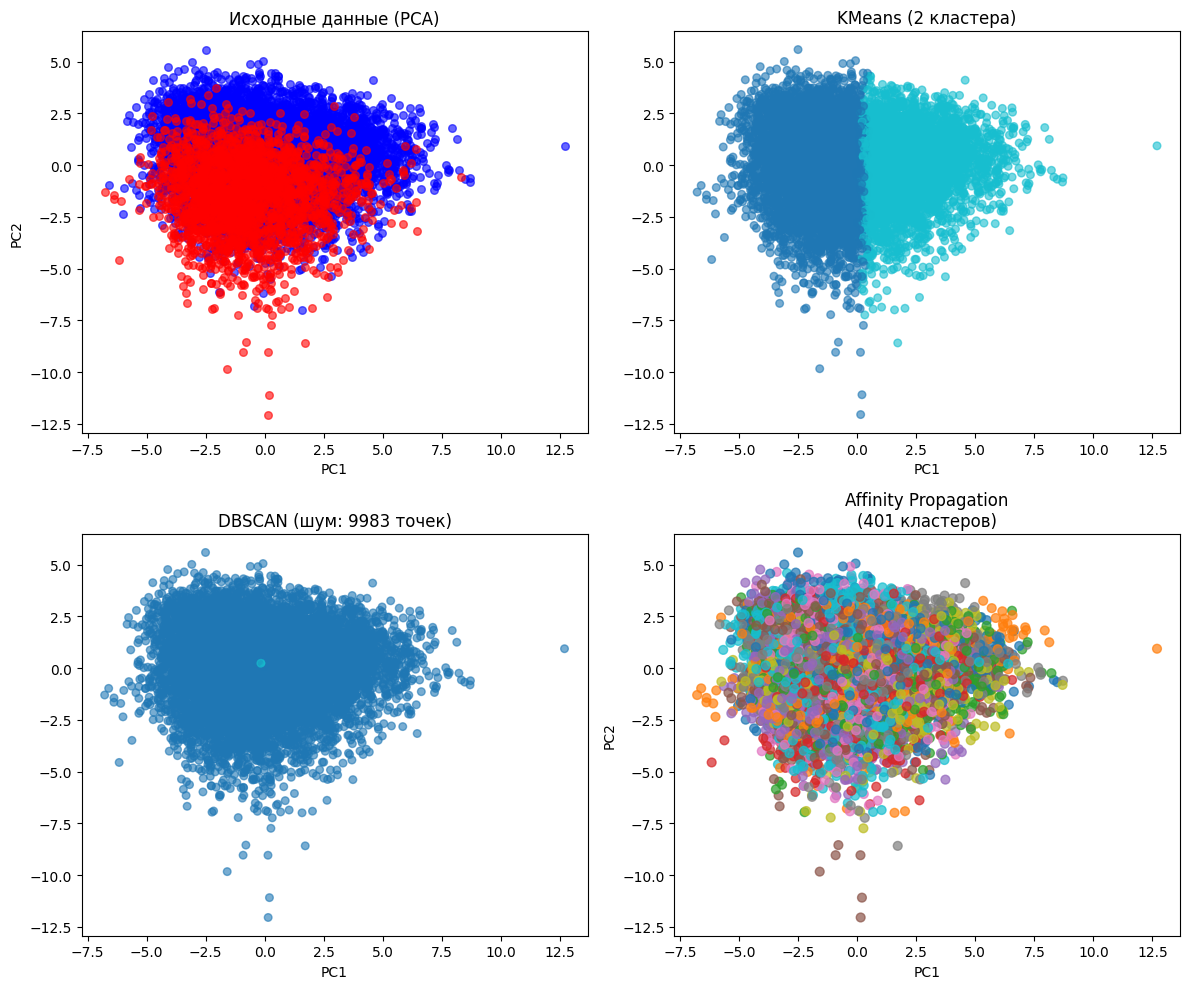

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Исходные данные после PCA
axes[0, 0].scatter(X_pca[y_true_encoded == 0, 0], X_pca[y_true_encoded == 0, 1],
                   c='blue', alpha=0.6, s=30, label='No Rain')
axes[0, 0].scatter(X_pca[y_true_encoded == 1, 0], X_pca[y_true_encoded == 1, 1],
                   c='red', alpha=0.6, s=30, label='Rain')
axes[0, 0].set_title('Исходные данные (PCA)')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
# KMeans
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, alpha=0.6, s=30, cmap='tab10')
axes[0, 1].set_title('KMeans (2 кластера)')
axes[0, 1].set_xlabel('PC1')

# DBSCAN
noise_count = sum(dbscan_labels == -1)
axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, alpha=0.6, s=30, cmap='tab10')
axes[1, 0].set_title(f'DBSCAN (шум: {noise_count} точек)')
axes[1, 0].set_xlabel('PC1')

# Affinity Propagation
n_clusters_affinity = len(set(affinity_labels))
axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=affinity_labels,
                alpha=0.7, s=40, cmap='tab10')
axes[1, 1].set_title(f'Affinity Propagation\n({n_clusters_affinity} кластеров)')
axes[1, 1].set_xlabel('PC1')
axes[1, 1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

### Сравнение с истинными метками

In [96]:
from sklearn.metrics import adjusted_rand_score
kmeans_valid = kmeans_labels[valid_mask]
dbscan_valid = dbscan_labels[valid_mask]
affinity_valid = affinity_labels[valid_mask]

print(f"   KMeans:           {adjusted_rand_score(y_true_valid, kmeans_valid):.4f}")
print(f"   DBSCAN:           {adjusted_rand_score(y_true_valid, dbscan_valid):.4f}")
print(f"   Affinity Prop.:   {adjusted_rand_score(y_true_valid, affinity_valid):.4f}")

   KMeans:           -0.0039
   DBSCAN:           -0.0004
   Affinity Prop.:   0.0009


### Выводы
Видно, что точки данных на 2D перемешаны (красное облако вклинивается в синее).

KMeans что для 2, что для 3 кластеров просто делит пространство на примерно равные части. Видимо в моиз данных нет естественных кластеров (это кстати видно по алгоритму AffinityPropagation и его 401 кластеру).

По результату DBSCAN видно, что данные в пространстве 20 признаков распределены равномерно. В данных нет плотных кластеров вообще. Конечно возможно, что 10к точек недостаточно, но иначе AffinityPropagation падает из-за недостатка памяти (и не только он, но и все остальные методы кроме первых двух тоже...). Всего 17 точек образуют два крошечных скопления.

AffinityPropagation на 10000 точек нашел 401 кластер, т.е. примерно каждые 25 точек образуют кластер. Для задачи кластеризации получилось слишком много кластеров - видимо возникло переобучение.

Результаты по adjust_rand_score тоже неутешительные - они показывают, что все совпадения с истинными метками в основном случайные.

Из всего можно сделать вывод, что эти данные не подходят для задачи кластеризации - данные достаточно равномерно распределены и возникает переобучение. Вполне возможно, что стоит использовать большее количество точек (но третий метод у меня постоянно падает на большем количестве точек). Лучше всего на этих данных использовать обучение с учителем и решать задачу классификации.